# Convex unmixer

Notebook that uses a network representation of sample localities to unmix sedimentary geochemical data. 

In [1]:
import os
import sys
import pandas as pd
print(sys.version)
print(os.getcwd())

import cvxpy as cp
import geochem_inverse_optimize as gio
import matplotlib.pyplot as plt

3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
/home/alex/Documents/scripts/faster-unmixer-richard


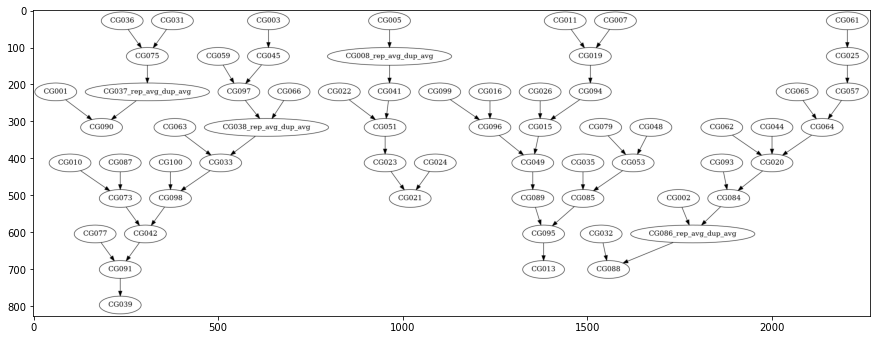

Compiling and solving problem...

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +2e+03  8e-01  7e-01  1e+00  6e+00    ---    ---    1  1  - |  -  - 
 1  +8.499e+01  +8.735e+01  +8e+02  5e-01  5e-01  3e+00  3e+00  0.6574  3e-01   1  1  1 |  0  0
 2  +7.426e+01  +7.547e+01  +2e+02  8e-02  1e-01  1e+00  6e-01  0.8272  3e-02   1  1  1 |  0  0
 3  +7.188e+01  +7.257e+01  +4e+01  3e-02  3e-02  7e-01  2e-01  0.8235  1e-01   1  1  1 |  0  0
 4  +7.154e+01  +7.203e+01  +2e+01  2e-02  2e-02  5e-01  8e-02  0.7697  3e-01   2  1  1 |  0  0
 5  +6.967e+01  +6.989e+01  +5e+00  5e-03  6e-03  2e-01  2e-02  0.8099  3e-02   2  1  2 |  0  0
 6  +6.862e+01  +6.877e+01  +2e+00  3e-03  3e-03  1e-01  1e-02  0.6693  3e-01   1  1  1 |  0  0
 7  +6.779e+01  +6.787e+01  +1e+00  2e-03  2e-03  8e-02  5e-03  0.9382  5e-01   1  1  1 |  0  0
 8  +6.731e+0

In [5]:
obs_data = pd.read_csv("data/geochem_no_dupes.dat", delimiter=" ") 
obs_data = obs_data.drop(columns=['Bi', 'S'])

element = 'Li'
sample_network, sample_adjacency = gio.get_sample_graphs("data/")
plt.figure(figsize=(15,10))
gio.plot_network(sample_network)
element_data = gio.get_element_obs(element,obs_data) # Return dictionary of {sample_name:concentration}
element_pred = gio.process_element(sample_network=sample_network,
                    sample_adjacency=sample_adjacency,
                    obs_data= element_data,
                    regularizer_strength=  1e-3)